In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
import os 



# Main Analysis - Life Expectancy Dataset between 2000 - 2015

Dataset Preparation - Life Expectancy (WHO)

In [2]:
# Load dataset
df = pd.read_csv("Life-Expectancy-Data-Updated.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Make sure the key columns are numeric
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Life_expectancy"] = pd.to_numeric(df["Life_expectancy"], errors="coerce")

# Createn a "Status" column based on "Economy_status_Developed"
df['Status'] = df['Economy_status_Developed'].apply(lambda x: 'Developed' if x == 1 else 'Developing')

# Identify vaccination columns 
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in ["polio", "hepatitis", "diphtheria", "measles"])]

# Calculate the average vaccination rate for each row (Country/Year)
df['avg_vaccination'] = df[vacc_cols].mean(axis=1)


## Average Vaccination Rates by Region

C:\Users\Shir\AppData\Local\Temp\ipykernel_11628\1658924521.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


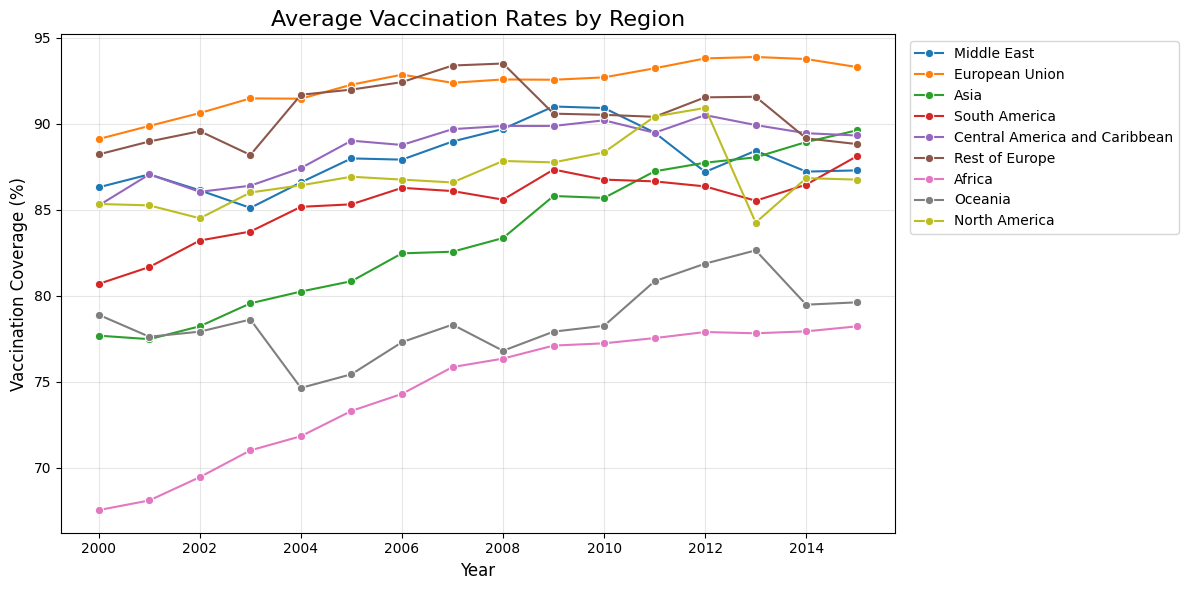

In [4]:

plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df, 
    x="Year", 
    y="avg_vaccination", 
    hue="Region", 
    marker="o",
    ci=None  # Remove confidence interval shading for cleaner lines
)

plt.title("Average Vaccination Rates by Region", fontsize=16)
plt.ylabel("Vaccination Coverage (%)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

Looking at the region granularity, we can't really draw any conclusions of vaccination progress by year.

## Development Status Analysis

Analyzing by country, we want to compare trends in developed and developing countries. We first look at the effect of vaccination on child mortality.

Correlation (Developed Countries): 0.1011


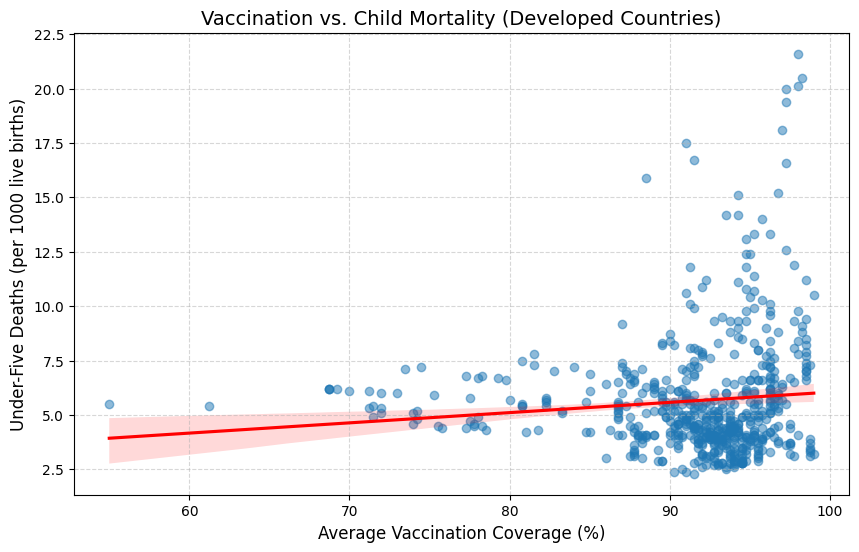

In [6]:
# Filter for Developed Countries
developed_df = df[df['Status'] == 'Developed'].copy()

# Calculate Correlation
correlation = developed_df['avg_vaccination'].corr(developed_df['Under_five_deaths'])
print(f"Correlation (Developed Countries): {correlation:.4f}")

plt.figure(figsize=(10, 6))

sns.regplot(
    data=developed_df,
    x='avg_vaccination',
    y='Under_five_deaths',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.title(f'Vaccination vs. Child Mortality (Developed Countries)', fontsize=14)
plt.xlabel('Average Vaccination Coverage (%)', fontsize=12)
plt.ylabel('Under-Five Deaths (per 1000 live births)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

We can see that in developed countries, vaccination coverage doesn't necessarily decrease child mortality - as developed countries mostly already have high vaccination rates, increasing the vaccination coverage doesn't result in a decline in child mortality.

Correlation (Developing Countries): -0.7086


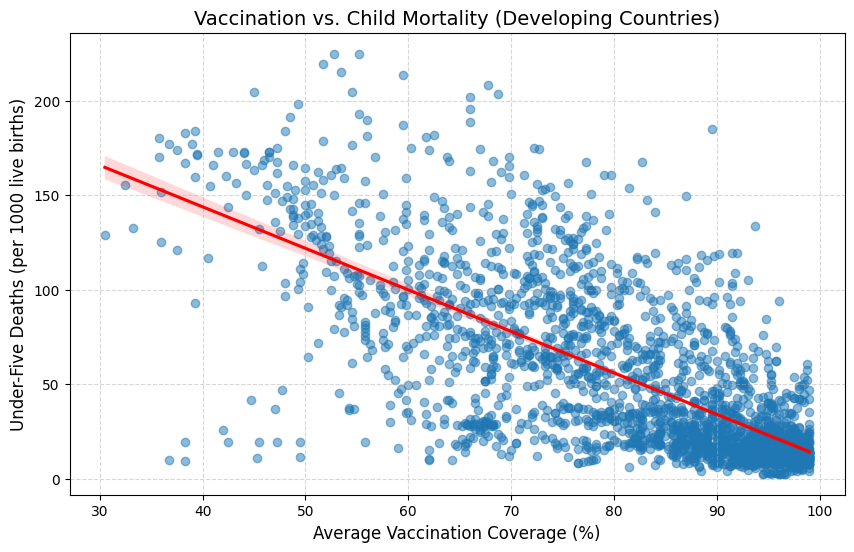

In [7]:
# Filter for Developing Countries
developing_df = df[df['Status'] == 'Developing'].copy()

# Calculate Correlation
correlation = developing_df['avg_vaccination'].corr(developing_df['Under_five_deaths'])
print(f"Correlation (Developing Countries): {correlation:.4f}")

plt.figure(figsize=(10, 6))

sns.regplot(
    data=developing_df,
    x='avg_vaccination',
    y='Under_five_deaths',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.title(f'Vaccination vs. Child Mortality (Developing Countries)', fontsize=14)
plt.xlabel('Average Vaccination Coverage (%)', fontsize=12)
plt.ylabel('Under-Five Deaths (per 1000 live births)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In developing coutries we can see that an increase in vaccination rates correlates strongly with a decrease in child mortality, suggesting the effect of vaccination on child mortality is not yet saturated in these countries.

### log(GDP) and Vaccination Coverage by Development Status - Surprising Trend

Correlation (Log GDP vs Vaccination):
Status             
Developed   log_GDP   -0.332358
Developing  log_GDP    0.536635
Name: avg_vaccination, dtype: float64


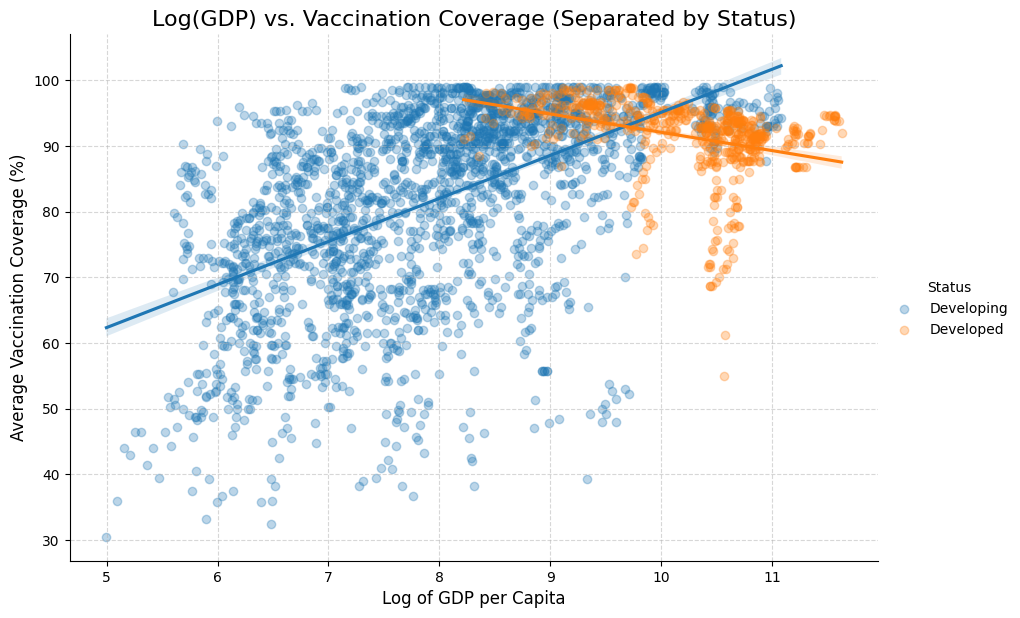

In [ ]:
# Calculate Log GDP (for better visualization)
df['log_GDP'] = np.log(df['GDP_per_capita'])

# Calculate Correlations for each group
stats = df.groupby('Status')[['log_GDP', 'avg_vaccination']].corr().iloc[0::2, -1]
print("Correlation (Log GDP vs Vaccination):")
print(stats)

sns.lmplot(
    data=df, 
    x='log_GDP', 
    y='avg_vaccination', 
    hue='Status', 
    height=6, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3}
)

plt.title('Log(GDP) vs. Vaccination Coverage (Separated by Status)', fontsize=16)
plt.xlabel('Log of GDP per Capita', fontsize=12)
plt.ylabel('Average Vaccination Coverage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

We can see a surprising negative correlation between GDP and Vaccination Rates in Developed countries - it appears as though as developed countries get richer, they experience a decrease in their vaccination coverage.

Motivated by the previous result, we incorporate HDI data into our dataset, to analyze the extent of this trend.

In [10]:

df_hdi = pd.read_csv("hdr_general.csv", encoding='latin1')
# Clean column names
df_hdi.columns = df_hdi.columns.str.strip()

# Make sure the key columns are numeric
df_hdi["year"] = pd.to_numeric(df_hdi["year"], errors="coerce")
df_hdi["hdi"] = pd.to_numeric(df_hdi["hdi"], errors="coerce")

# Keep only rows we need
df_hdi_small = df_hdi.dropna(subset=["year", "hdi"]).copy()
df_hdi_small["year"] = df_hdi_small["year"].astype(int)

df_hdi_small = df_hdi_small[['country', 'year', 'hdi']]

# Perform the Join
combined_df = pd.merge(
    df, 
    df_hdi_small, 
    left_on=['Country', 'Year'], 
    right_on=['country', 'year'],
    how='inner'
)

# Check the result
print(combined_df.head())

      Country                         Region  Year  Infant_deaths  \
0       Spain                 European Union  2015            2.7   
1       India                           Asia  2007           51.5   
2      Guyana                  South America  2006           32.8   
3      Israel                    Middle East  2012            3.4   
4  Costa Rica  Central America and Caribbean  2006            9.8   

   Under_five_deaths  Adult_mortality  Alcohol_consumption  Hepatitis_B  \
0                3.3          57.9025                10.35           97   
1               67.9         201.0765                 1.57           60   
2               40.5         222.1965                 5.68           93   
3                4.3          57.9510                 2.89           97   
4               11.2          95.2200                 4.19           88   

   Measles   BMI  ...  Schooling  Economy_status_Developed  \
0       94  26.0  ...        9.7                         1   
1       35

We then check the HDI vs. Vaccination Coverage trend in developed and developing countries to see if it matches the GDP vs. Vaccination Coverage trend.

In [11]:

print("Correlation (HDI vs Vaccination) with P-values:")
print("-" * 50)

for status, group_data in combined_df.groupby('Status'):
    
    subset = group_data[['hdi', 'avg_vaccination']]
    
    corr, p_val = pearsonr(subset['hdi'], subset['avg_vaccination'])
    
    print(f"Status: {status}")
    print(f"  Correlation (r): {corr:.3f}")
    print(f"  P-value:         {p_val:.4e}") 
    
    print("-" * 50)

Correlation (HDI vs Vaccination) with P-values:
--------------------------------------------------
Status: Developed
  Correlation (r): -0.204
  P-value:         8.2033e-07
--------------------------------------------------
Status: Developing
  Correlation (r): 0.668
  P-value:         1.7786e-243
--------------------------------------------------


We can see a statistically significant negative correlation between HDI and Vaccination rates in developed countries, similar to the GDP trend.

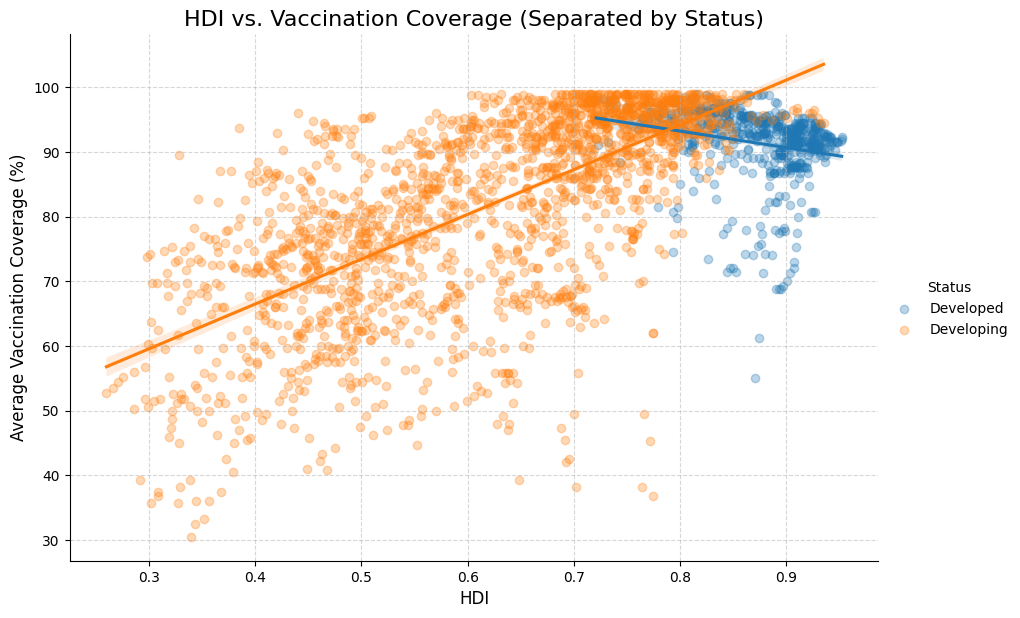

In [14]:
sns.lmplot(
    data=combined_df, 
    x='hdi', 
    y='avg_vaccination', 
    hue='Status', 
    height=6, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3}
)

plt.title('HDI vs. Vaccination Coverage (Separated by Status)', fontsize=16)
plt.xlabel('HDI', fontsize=12)
plt.ylabel('Average Vaccination Coverage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

We can also see the same trend in graph form.

### Surprising Trend Explanation - Simpson's Paradox

We first look at individual countries correlation between HDI at different time points and Vaccination Coverage.

C:\Users\Shir\AppData\Local\Temp\ipykernel_11628\1996287933.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['hdi'].corr(g['avg_vaccination']))
C:\Users\Shir\AppData\Local\Temp\ipykernel_11628\1996287933.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


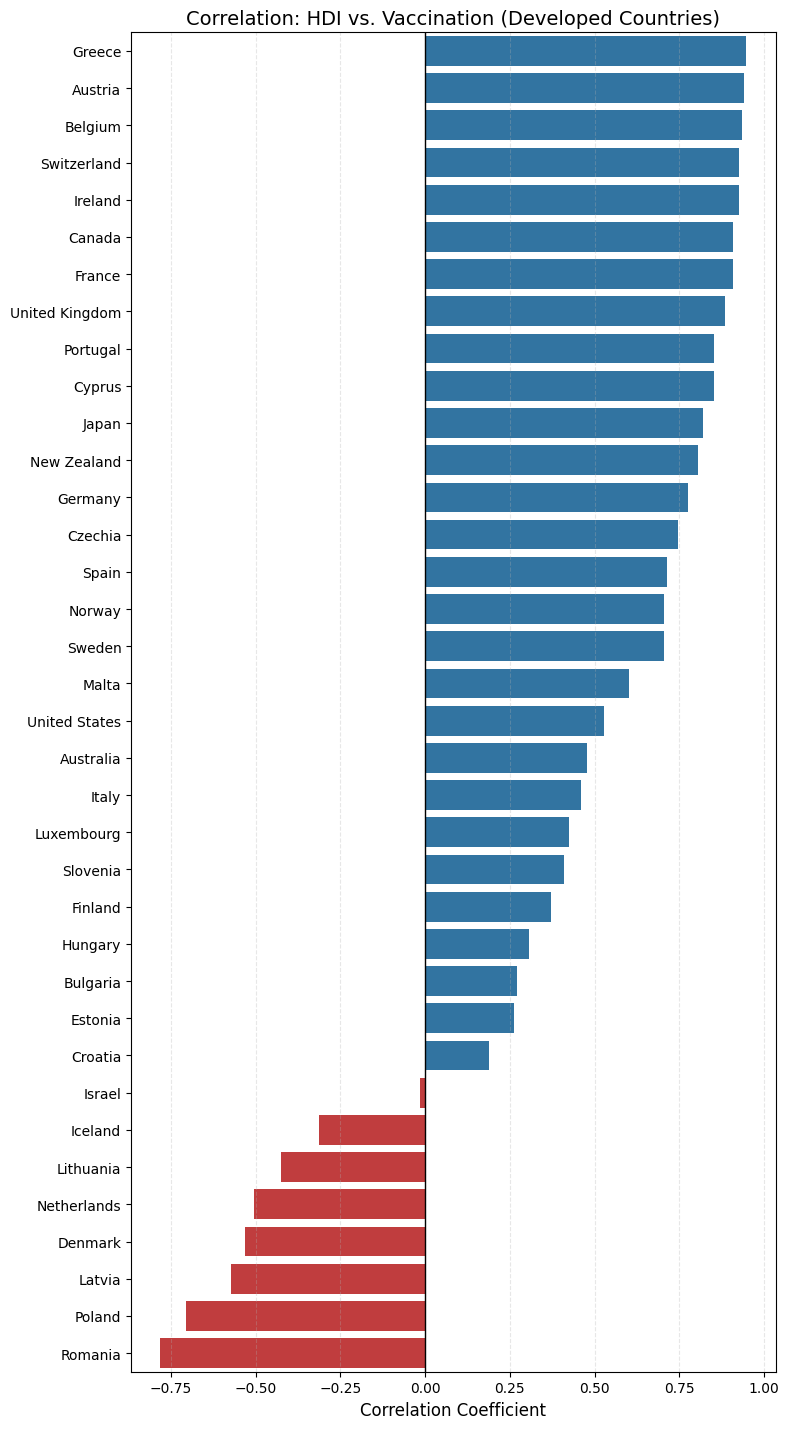

In [17]:

correlations = (
    combined_df[combined_df["Status"] == "Developed"]
    .groupby('Country')
    .apply(lambda g: g['hdi'].corr(g['avg_vaccination'])) 
    .sort_values(ascending=False)                        
    .reset_index(name='Correlation')                      
)

plt.figure(figsize=(8, len(correlations) * 0.4)) 

custom_colors = ['#1f77b4' if x > 0 else '#d62728' for x in correlations['Correlation']]

sns.barplot(
    data=correlations, 
    x='Correlation', 
    y='Country', 
    palette=custom_colors
)

plt.title('Correlation: HDI vs. Vaccination (Developed Countries)', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel(None) 
plt.axvline(0, color='black', linewidth=1) 
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

We can see positive correlations across most countries, meaning in-country vaccination coverage mostly does increase with HDI.

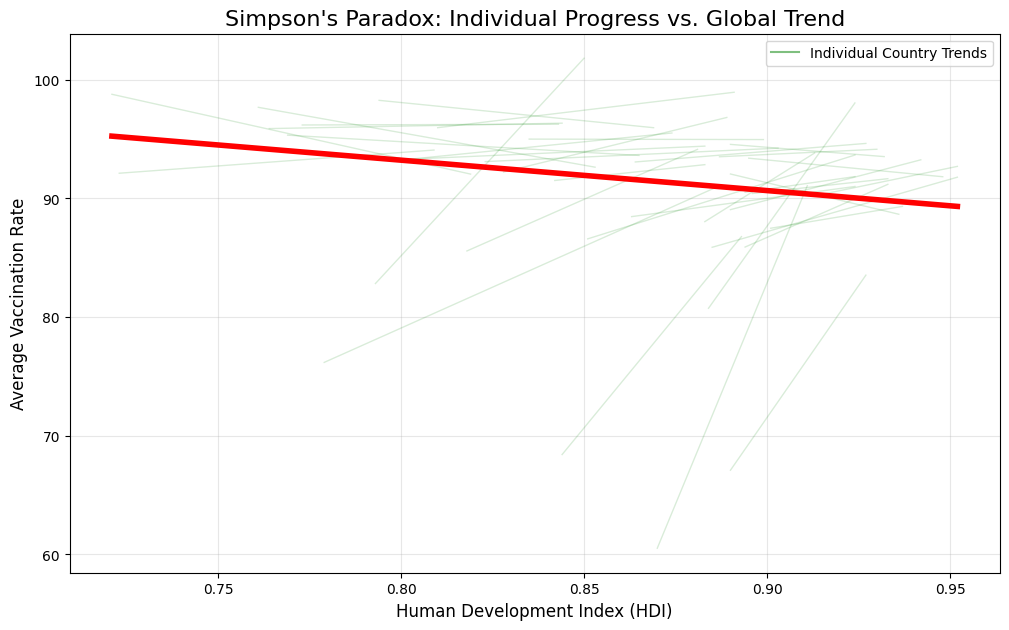

In [ ]:
dev_df = combined_df[combined_df["Status"] == "Developed"].copy()

plt.figure(figsize=(12, 7))

# Plot INDIVIDUAL Country Trends (The "Spaghetti")
for country in dev_df['Country'].unique():
    subset = dev_df[dev_df['Country'] == country]
    # Only plot if we have enough data points
    if len(subset) > 5:
        sns.regplot(
            x=subset['hdi'], 
            y=subset['avg_vaccination'], 
            ci=None, 
            scatter=False,    
            line_kws={'alpha': 0.15, 'color': 'green', 'linewidth': 1} 
        )

# Plot the GLOBAL Trend (The "Paradox")
sns.regplot(
    data=dev_df, 
    x='hdi', 
    y='avg_vaccination', 
    scatter=False, 
    ci=None,
    line_kws={'color': 'red', 'linewidth': 4, 'label': 'Global Trend (All Data)'}
)

plt.plot([], [], color='green', alpha=0.5, label='Individual Country Trends')

plt.title("Simpson's Paradox: Individual Progress vs. Global Trend", fontsize=16)
plt.xlabel("Human Development Index (HDI)", fontsize=12)
plt.ylabel("Average Vaccination Rate", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

C:\Users\Shir\AppData\Local\Temp\ipykernel_11628\456925934.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left')


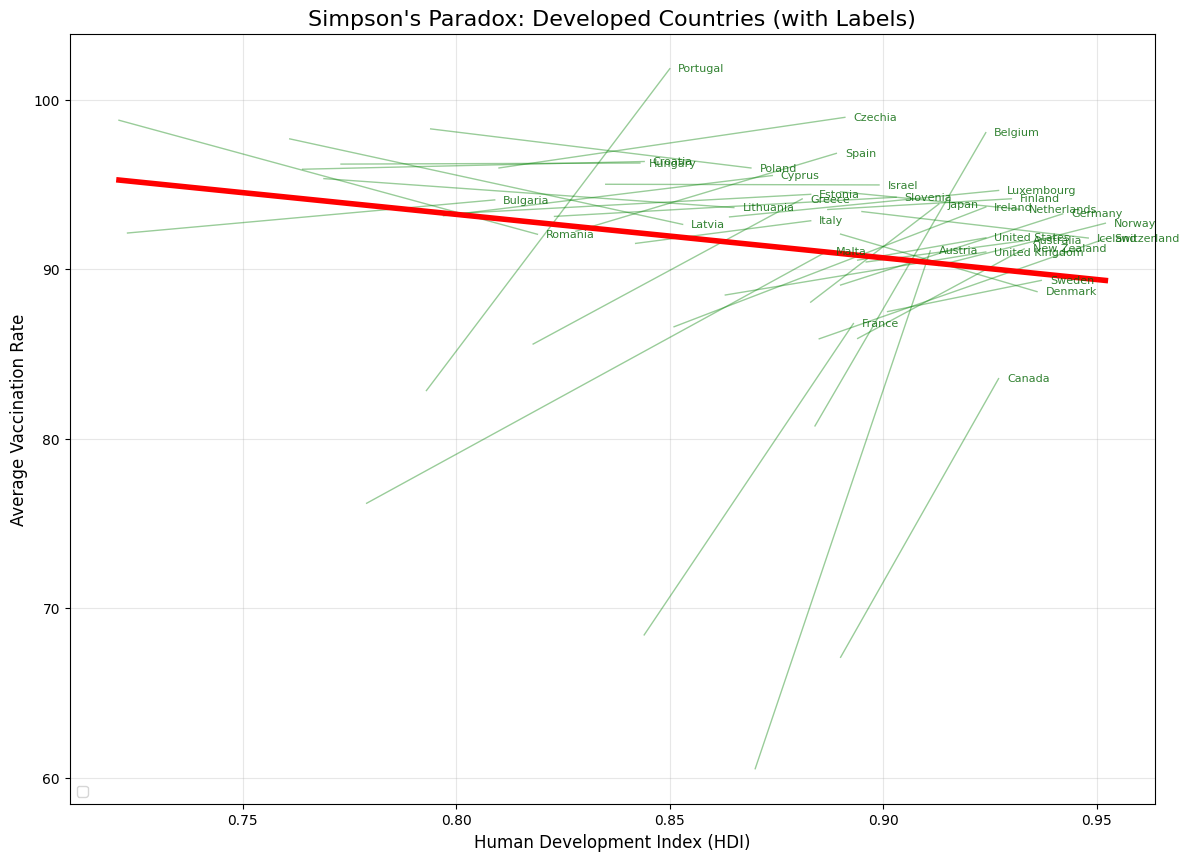

In [19]:

plt.figure(figsize=(14, 10))  

for country in dev_df['Country'].unique():
    subset = dev_df[dev_df['Country'] == country]
    
    if len(subset) > 5:
        sns.regplot(
            data=subset,
            x='hdi', 
            y='avg_vaccination', 
            ci=None, 
            scatter=False, 
            line_kws={'alpha': 0.4, 'color': 'green', 'linewidth': 1} 
        )
        
        # add country names at the end of each line
        if subset['hdi'].nunique() > 1:
            m, b = np.polyfit(subset['hdi'], subset['avg_vaccination'], 1)
            
            x_pos = subset['hdi'].max()
            y_pos = m * x_pos + b
            
            plt.text(
                x_pos + 0.002,  # Shift slightly right for spacing
                y_pos, 
                country, 
                color='darkgreen', 
                fontsize=8, 
                alpha=0.8,
                verticalalignment='center'
            )

sns.regplot(
    data=dev_df, 
    x='hdi', 
    y='avg_vaccination', 
    scatter=False, 
    ci=None,
    line_kws={'color': 'red', 'linewidth': 4, 'label': 'Global Trend (Negative Correlation)'}
)

plt.title("Simpson's Paradox: Developed Countries (with Labels)", fontsize=16)
plt.xlabel("Human Development Index (HDI)", fontsize=12)
plt.ylabel("Average Vaccination Rate", fontsize=12)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

plt.show()

We can conclude there's a case of Simpson's Paradox in our data - the global trend does not match the local trend when looking at individual countries.

## Additional Analysis - COVID-19 Period

We wanted to explore the vaccination coverage trend in COVID-19 years, which were not present in our main dataset. For that, we extracted more recent data (up to 2024) from the WHO portal. Because we don't have HDI data for more recent years (only up to 2022), we mostly look at vaccination trends over time, both before and after COVID-19, to search for temporal changes between these periods.

In [23]:
file_map = {
    'DTP3.csv': 'DTP3',
    'HepB3.csv': 'HepB3',
    'MCV1.csv': 'MCV1',
    'Pol3.csv': 'Pol3',
}

final_df = None

for filename, vacc_name in file_map.items():
    if os.path.exists(filename):        
        temp_df = pd.read_csv(filename)
        
        # SELECT & RENAME COLUMNS
        # The new WHO files use specific column headers:
        # 'Location' -> Country
        # 'Period'   -> Year
        # 'FactValueNumeric' -> The actual number (cleaner than 'Value')
        df_clean = temp_df[['Location', 'Period', 'FactValueNumeric']].copy()
        df_clean.columns = ['Country', 'Year', vacc_name]
                
        # Country name fixes
        df_clean['Country'] = df_clean['Country'].replace(
            "United States of America", "United States"
        )
        df_clean['Country'] = df_clean['Country'].replace(
            "United Kingdom of Great Britain and Northern Ireland", "United Kingdom"
        )
        
        # Merge
        if final_df is None:
            final_df = df_clean
        else:
            final_df = pd.merge(final_df, df_clean, on=['Country', 'Year'], how='inner')

if final_df is not None:
    # Sort by Country and Year
    final_df = final_df.sort_values(['Country', 'Year']).reset_index(drop=True)
    
    # Calculate Average Vaccination Rates
    vaccine_cols = list(file_map.values())
    final_df['average_vaccination'] = final_df[vaccine_cols].replace(0, np.nan).mean(axis=1)

    print(final_df.head())

       Country  Year  DTP3  HepB3  MCV1  Pol3  average_vaccination
0  Afghanistan  2000    24      0    27    24            25.000000
1  Afghanistan  2001    33      0    37    35            35.000000
2  Afghanistan  2002    36      0    35    36            35.666667
3  Afghanistan  2003    41      0    39    41            40.333333
4  Afghanistan  2004    50      0    48    50            49.333333


In [ ]:
# include HDI where possible
combined_df_new_dataset = pd.merge(
    final_df, 
    df_hdi_small, 
    left_on=['Country', 'Year'], 
    right_on=['country', 'year'],
    how='inner'
)

In [25]:
df_status = df[['Country', 'Status']].drop_duplicates()

combined_df_with_status = pd.merge(
    combined_df_new_dataset, 
    df_status, 
    left_on=['Country'], 
    right_on=['Country'],
    how='left'
)

combined_df_with_status = combined_df_with_status[['Country', 'Year', 'average_vaccination', 'hdi', 'Status']]

print(combined_df_with_status.head())



       Country  Year  average_vaccination    hdi      Status
0  Afghanistan  2000            25.000000  0.340  Developing
1  Afghanistan  2001            35.000000  0.344  Developing
2  Afghanistan  2002            35.666667  0.368  Developing
3  Afghanistan  2003            40.333333  0.379  Developing
4  Afghanistan  2004            49.333333  0.395  Developing


We look at the same trend as before but only on the new data.

Correlation (HDI vs Vaccination):
Status         
Developed   hdi    0.007807
Developing  hdi    0.485713
Name: average_vaccination, dtype: float64


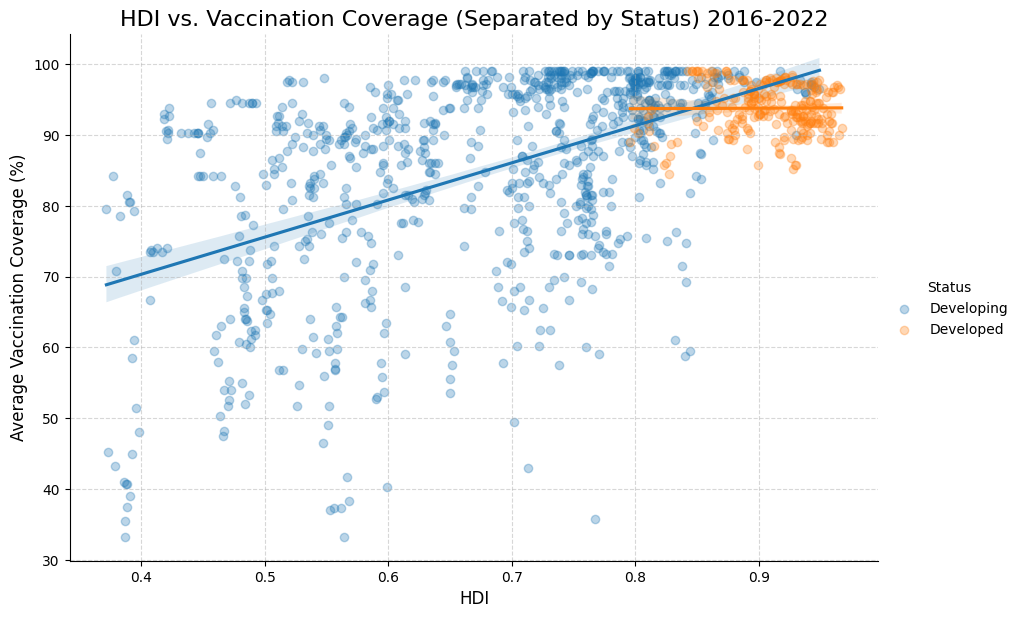

In [27]:
df_from_2016 = combined_df_with_status.loc[combined_df_with_status['Year'] >= 2016]

stats = df_from_2016.groupby('Status')[['hdi', 'average_vaccination']].corr().iloc[0::2, -1]
print("Correlation (HDI vs Vaccination):")
print(stats)


sns.lmplot(
    data=df_from_2016, 
    x='hdi', 
    y='average_vaccination', 
    hue='Status', 
    height=6, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3}
)

plt.title('HDI vs. Vaccination Coverage (Separated by Status) 2016-2022', fontsize=16)
plt.xlabel('HDI', fontsize=12)
plt.ylabel('Average Vaccination Coverage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

On the global level, we can see a weaker trend - the correlation is very close to 0 on developed countries, and weaker in developing countries.

C:\Users\Shir\AppData\Local\Temp\ipykernel_11628\827903282.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


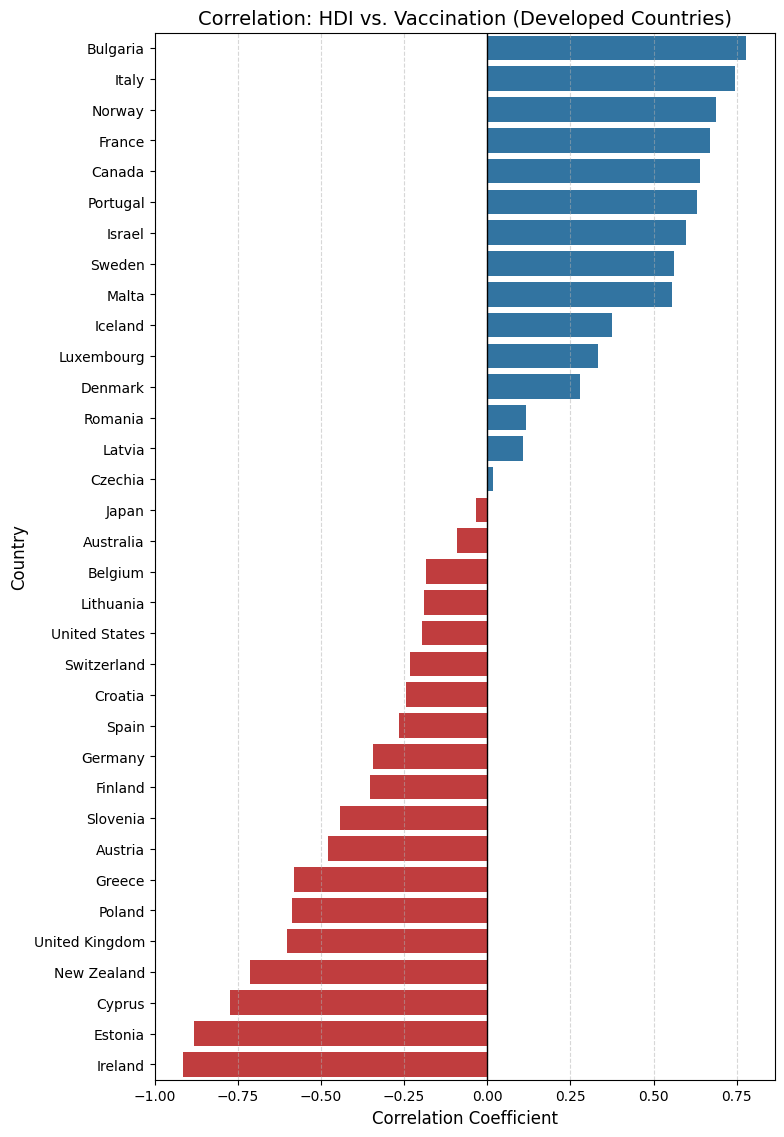

In [29]:
corr_df = stats.reset_index()

corr_df.columns = ['Country', 'Variable', 'Correlation'] # 'Variable' is the 'hdi' level we don't need
corr_df = corr_df[['Country', 'Correlation']].sort_values('Correlation', ascending=False)
corr_df = corr_df.dropna()

plt.figure(figsize=(8, len(corr_df) * 0.4))  # Auto-adjust height based on N countries

colors = ['#1f77b4' if x > 0 else '#d62728' for x in corr_df['Correlation']]

sns.barplot(
    data=corr_df, 
    x='Correlation', 
    y='Country', 
    palette=colors  # Blue for positive, Red for negative
)

plt.title('Correlation: HDI vs. Vaccination (Developed Countries)', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.axvline(0, color='black', linewidth=1) # Add a vertical line at 0 for reference
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

We can see that on the individual level we now have more countries with a negative correlation between HDI and Vaccination Rates.

Motivated by the previous results, we want to see the temporal trend - we hypothesize that on the country level we should see a decrease in vaccination rates through the COVID-19 years, as the anti-vaccination movement became more outspoken.

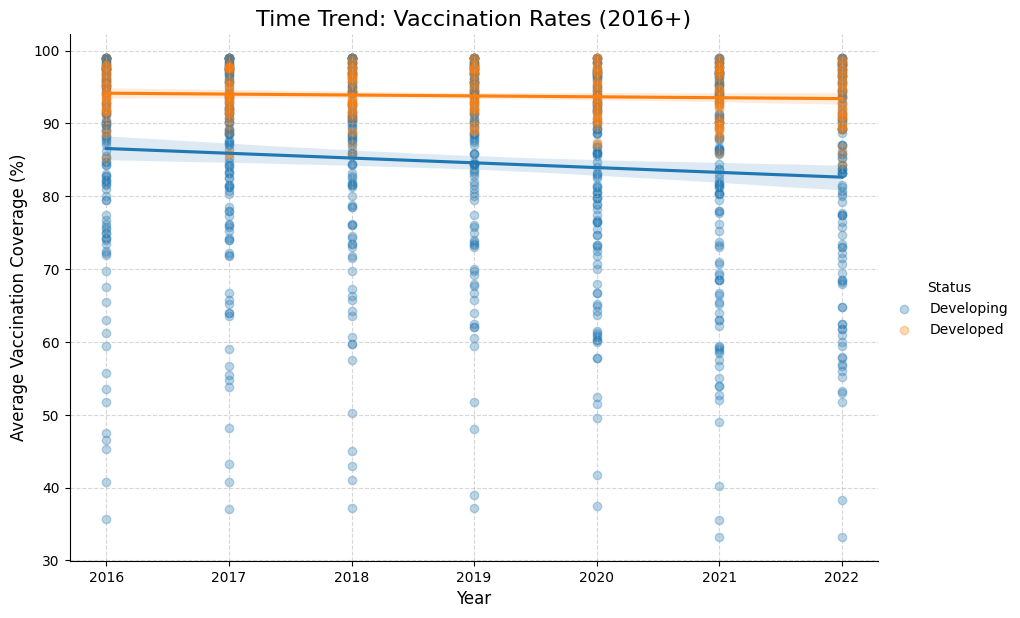

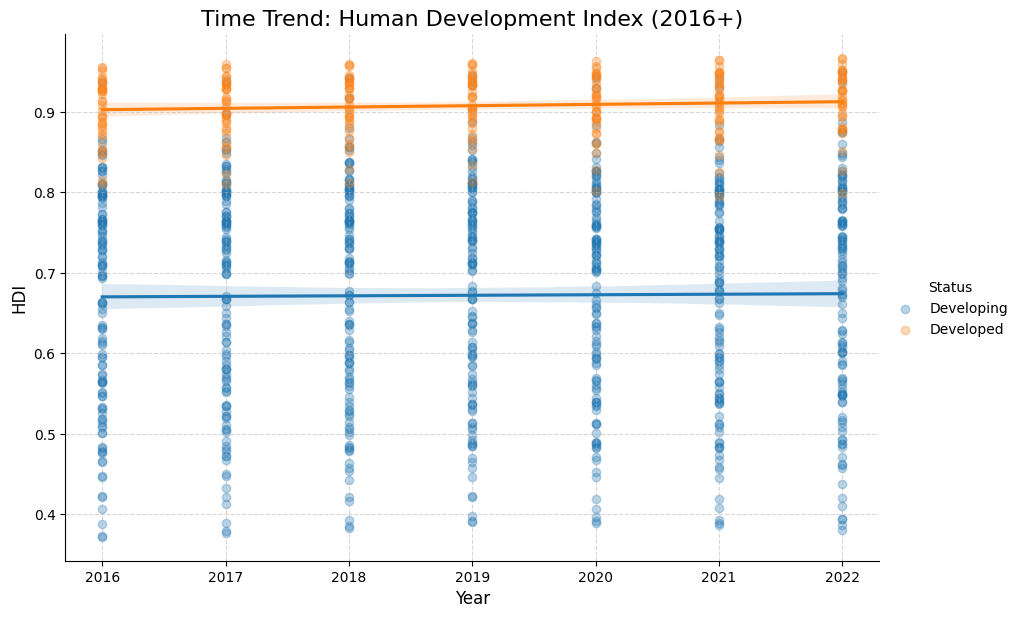

In [31]:

df_from_2016 = df_from_2016.sort_values('Year')

sns.lmplot(
    data=df_from_2016, 
    x='Year', 
    y='average_vaccination', 
    hue='Status', 
    height=6, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3},
    x_estimator=None 
)

plt.title('Time Trend: Vaccination Rates (2016+)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Vaccination Coverage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


sns.lmplot(
    data=df_from_2016, 
    x='Year', 
    y='hdi', 
    hue='Status', 
    height=6, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3}
)

plt.title('Time Trend: Human Development Index (2016+)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('HDI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

We can see that on the global level, vaccination coverage in developed countries stagnates, while decreasing in developing countries - a trend that starts even before COVID-19 years.
We can also see an HDI stagnation on the global level in both developed and developing countries in the portrayed time frame.

We focus on the developed countries, as we aim to compare to our main analysis. We then utilize all of our data (up to 2024) to look at the temporal trend.

In [33]:
df_status = df[['Country', 'Status']].drop_duplicates()

df_all_years_with_status = pd.merge(
    final_df, 
    df_status, 
    left_on=['Country'], 
    right_on=['Country'],
    how='left'
)

df_all_years_with_status = df_all_years_with_status[['Country', 'Year', 'average_vaccination', 'Status']]

print(df_all_years_with_status.head())



       Country  Year  average_vaccination      Status
0  Afghanistan  2000            25.000000  Developing
1  Afghanistan  2001            35.000000  Developing
2  Afghanistan  2002            35.666667  Developing
3  Afghanistan  2003            40.333333  Developing
4  Afghanistan  2004            49.333333  Developing


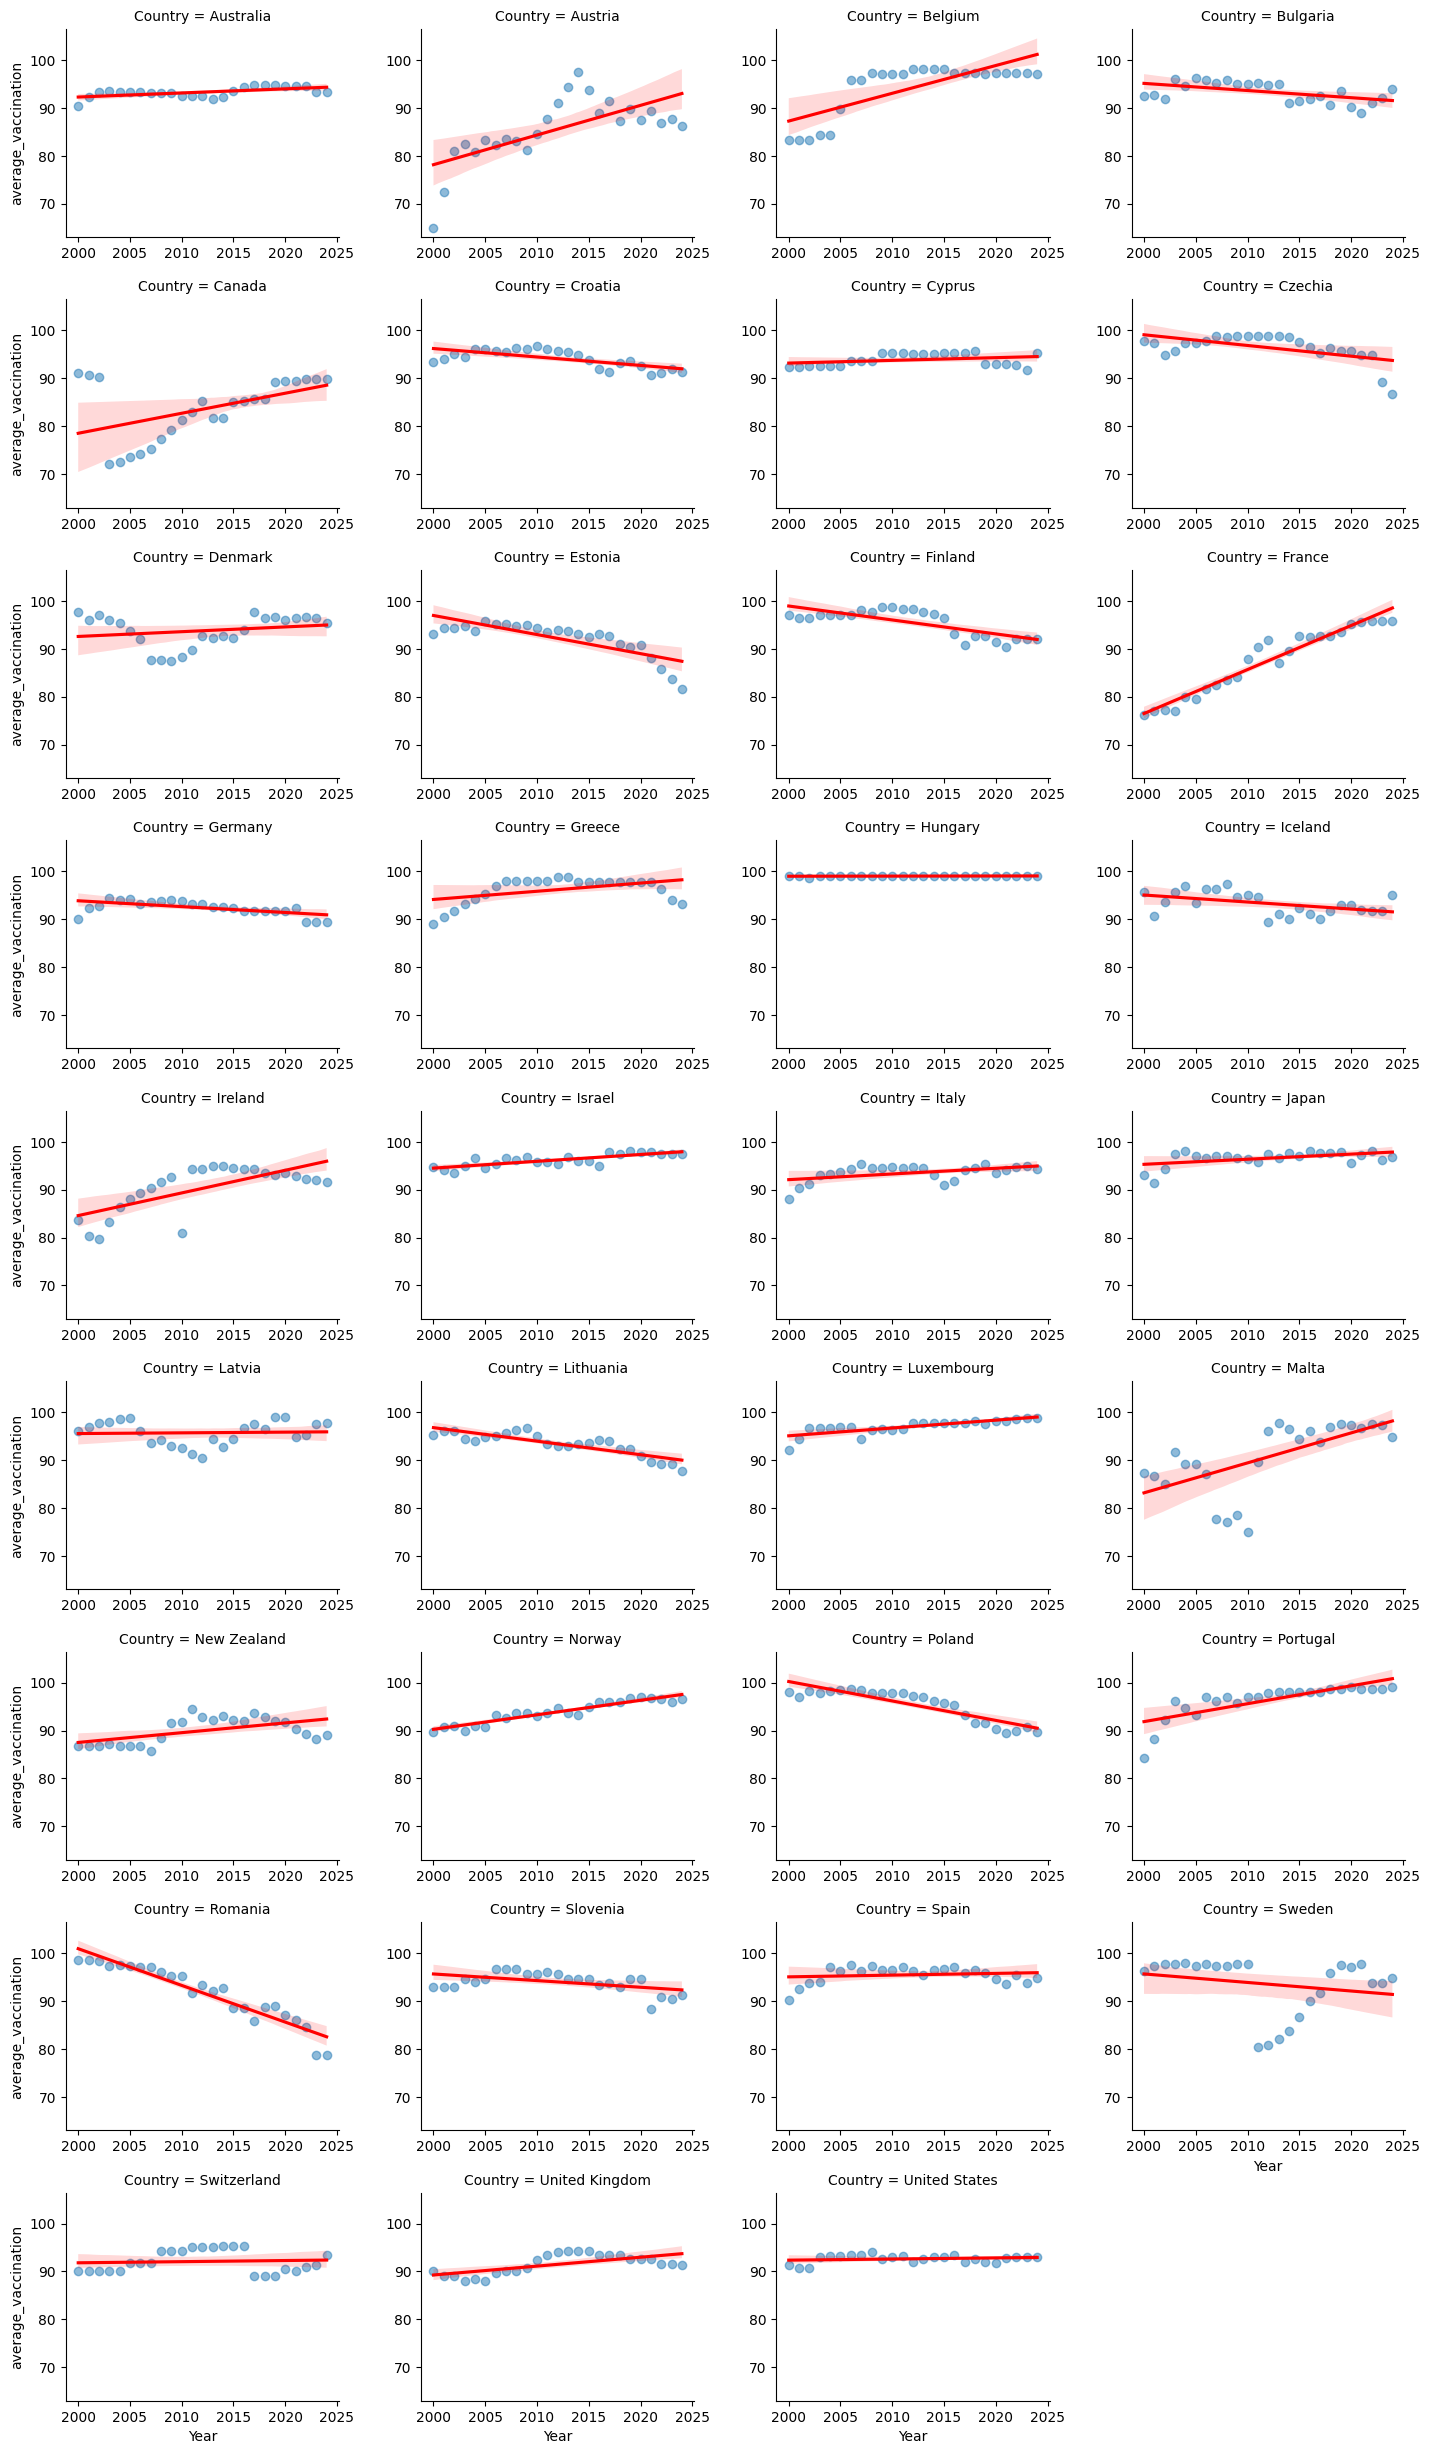

In [34]:
df_developed = df_all_years_with_status[df_all_years_with_status['Status'] == 'Developed'].copy()

g = sns.lmplot(
    data=df_developed, 
    x='Year', 
    y='average_vaccination', 
    col='Country', 
    col_wrap=4, 
    height=3, 
    aspect=1.2, 
    line_kws={'color': 'red'}, 
    scatter_kws={'alpha': 0.5}
)


for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True, labelleft=True)

# Adjust title and spacing
plt.subplots_adjust(top=0.9, hspace=0.3, wspace=0.3) 
plt.show()

The above plots show temporal changes in vaccination rates across all available years (2000 - 2024). In most countries, no new trends seem to emerge in COVID-19 years, and drops are mainly attributed to trend already established in previous years. As there's only one data-point per year for each country, inter-country trends over a short period of time are hard to observe, and may still exist.